<a href="https://colab.research.google.com/github/saffarizadeh/INSY5378/blob/main/Introduction_to_ML_Frameworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://kambizsaffari.com/Logo/College_of_Business.cmyk-hz-lg.png" width="500px"/>

# *INSY 5378 - Advanced AI*

# **Introduction to TensorFlow, PyTorch, JAX, and Keras**

Instructor: Dr. Kambiz Saffari

---

Note: You MUST read the chapter. Going through this notebook does not replace the value of reading the chapter.

Link to the chapter: https://deeplearningwithpython.io/chapters/chapter03_introduction-to-ml-frameworks/


This chapter covers:
- A closer look at all major deep learning frameworks
- Core concepts in TensorFlow, PyTorch, and JAX (tensors, gradients, compilation)
- Building an MNIST classifier in each framework
- Introduction to Keras: layers, models, compile, fit, and predict

## Why Do We Need Frameworks?

In Chapter 2, we built neural network components from scratch using NumPy. That was great for understanding the math, but in practice, we need three things NumPy alone can't provide:

1. **Automatic differentiation** - Computing gradients without hand-coding the backward pass
2. **GPU acceleration** - Running tensor operations on GPUs for massive speedups
3. **Distributed computation** - Scaling across multiple GPUs or machines

The four frameworks we cover today - **TensorFlow**, **PyTorch**, **JAX**, and **Keras** - all provide these capabilities, each with a different philosophy.

**Key distinction:** TensorFlow, PyTorch, and JAX are *low-level* frameworks (raw building materials). Keras is a *high-level* API (a prefabricated building kit) that runs on top of any of the three.

## Shared Setup: Loading MNIST

We'll use the same MNIST dataset from Chapter 2 as our running example throughout. Every framework below will train a model on the same data so you can compare them directly.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training subset: (5000, 784) images, (5000, 10) labels
Test subset:     (1000, 784) images, (1000, 10) labels


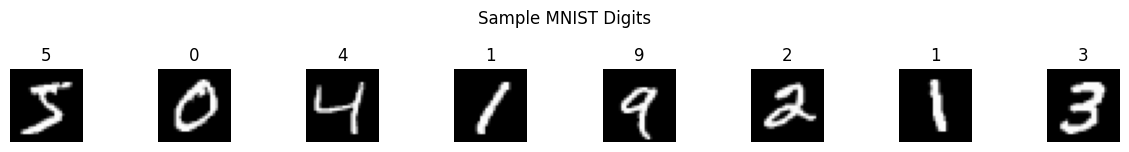

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Flatten 28x28 images to 784-dim vectors and normalize to [0, 1]
train_images = train_images.reshape((60000, 784)).astype("float32") / 255
test_images = test_images.reshape((10000, 784)).astype("float32") / 255

# One-hot encode labels (10 classes)
def one_hot(labels, num_classes=10):
    result = np.zeros((len(labels), num_classes), dtype="float32")
    result[np.arange(len(labels)), labels] = 1.0
    return result

train_labels_onehot = one_hot(train_labels)
test_labels_onehot = one_hot(test_labels)

# Use a smaller subset for the low-level examples (faster training)
X_train = train_images[:5000]
Y_train = train_labels_onehot[:5000]
X_test = test_images[:1000]
Y_test = test_labels_onehot[:1000]

print(f"Training subset: {X_train.shape} images, {Y_train.shape} labels")
print(f"Test subset:     {X_test.shape} images, {Y_test.shape} labels")

# Show a few examples
fig, axes = plt.subplots(1, 8, figsize=(12, 1.5))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap="gray")
    ax.set_title(str(train_labels[i]))
    ax.axis("off")
plt.suptitle("Sample MNIST Digits")
plt.tight_layout()
plt.show()

---
## 1. Introduction to TensorFlow

TensorFlow is developed by Google (released 2015). It emphasizes production deployment and compilation for performance.

### 1.1 Tensors and Variables

In [2]:
import tensorflow as tf

# Constant tensors (immutable) - similar to NumPy
a = tf.ones(shape=(2, 3))
b = tf.zeros(shape=(2, 3))
c = tf.constant([[1, 2], [3, 4]], dtype="float32")

print("Ones:\n", a.numpy())
print("\nConstant:\n", c.numpy())
print(f"Shape: {c.shape}, Dtype: {c.dtype}")

Ones:
 [[1. 1. 1.]
 [1. 1. 1.]]

Constant:
 [[1. 2.]
 [3. 4.]]
Shape: (2, 2), Dtype: <dtype: 'float32'>


In [3]:
# TF tensors are NOT assignable (unlike NumPy arrays)
x = tf.ones(shape=(2, 2))
try:
    x[0, 0] = 0.0
except TypeError as e:
    print(f"Error: {e}")

# Use tf.Variable for mutable state (this is how model weights are stored)
v = tf.Variable(initial_value=tf.random.normal(shape=(2, 2)))
print("\nOriginal:\n", v.numpy())

v.assign(tf.ones((2, 2)))
print("After assign:\n", v.numpy())

v[0, 0].assign(99.)
print("After partial assign:\n", v.numpy())

Error: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

Original:
 [[-0.13838136 -1.1634468 ]
 [-1.985702   -0.8575552 ]]
After assign:
 [[1. 1.]
 [1. 1.]]
After partial assign:
 [[99.  1.]
 [ 1.  1.]]


### 1.2 Tensor Operations

In [4]:
a = tf.constant([[1., 2.], [3., 4.]])
b = tf.constant([[5., 6.], [7., 8.]])

print("Element-wise add:\n", (a + b).numpy())
print("\nElement-wise square:\n", tf.square(a).numpy())
print("\nMatrix multiply (matmul):\n", tf.matmul(a, b).numpy())

# A Dense layer is just: relu(matmul(input, W) + b)
def dense(inputs, W, b):
    return tf.nn.relu(tf.matmul(inputs, W) + b)

Element-wise add:
 [[ 6.  8.]
 [10. 12.]]

Element-wise square:
 [[ 1.  4.]
 [ 9. 16.]]

Matrix multiply (matmul):
 [[19. 22.]
 [43. 50.]]


### 1.3 Computing Gradients with GradientTape

This is the key feature that separates TensorFlow from NumPy: **automatic differentiation**. Open a `GradientTape` scope, run some computation, then ask for the gradient.

In [5]:
# Simple example: gradient of x^2 at x=3
# We know d/dx(x^2) = 2x, so at x=3 the gradient should be 6
input_var = tf.Variable(initial_value=3.0)

with tf.GradientTape() as tape:
    result = tf.square(input_var)

gradient = tape.gradient(result, input_var)
print(f"f(x) = x^2 at x=3: {result.numpy()}")
print(f"f'(x) = 2x at x=3: {gradient.numpy()}")

f(x) = x^2 at x=3: 9.0
f'(x) = 2x at x=3: 6.0


In [6]:
# Gradients of a multi-variable function
W = tf.Variable(tf.random.normal((2, 2)))
b = tf.Variable(tf.zeros(2))
x = tf.constant([[1.0, 2.0]])

with tf.GradientTape() as tape:
    y = tf.matmul(x, W) + b
    loss = tf.reduce_sum(tf.square(y))

grad_W, grad_b = tape.gradient(loss, [W, b])
print(f"dL/dW shape: {grad_W.shape}")
print(f"dL/db shape: {grad_b.shape}")

dL/dW shape: (2, 2)
dL/db shape: (2,)


### 1.4 MNIST Classifier in Pure TensorFlow

Let's build a single-layer network (784 → 10) from scratch using only TensorFlow operations. No Keras - just tensors, variables, and GradientTape.

In [7]:
# Initialize weights
tf.random.set_seed(42)
W1 = tf.Variable(tf.random.normal((784, 10)) * 0.01)
b1 = tf.Variable(tf.zeros((10,)))

def tf_model(images):
    """Single layer: 784 -> 10"""
    return tf.nn.softmax(tf.matmul(images, W1) + b1)

def tf_loss(images, labels):
    predictions = tf_model(images)
    return tf.reduce_mean(tf.square(predictions - labels))

learning_rate = 0.5

def tf_training_step(images, labels):
    with tf.GradientTape() as tape:
        loss = tf_loss(images, labels)
    grad_W, grad_b = tape.gradient(loss, [W1, b1])
    W1.assign_sub(grad_W * learning_rate)
    b1.assign_sub(grad_b * learning_rate)
    return loss

# Training loop
print("Training single-layer MNIST classifier in pure TensorFlow...")
tf_inputs = tf.constant(X_train)
tf_labels = tf.constant(Y_train)

for epoch in range(50):
    loss = tf_training_step(tf_inputs, tf_labels)
    if epoch % 10 == 0:
        preds = tf_model(tf.constant(X_test))
        acc = np.mean(np.argmax(preds.numpy(), axis=1) == np.argmax(Y_test, axis=1))
        print(f"Epoch {epoch:3d}, Loss: {loss:.4f}, Test Acc: {acc:.3f}")

preds = tf_model(tf.constant(X_test))
acc = np.mean(np.argmax(preds.numpy(), axis=1) == np.argmax(Y_test, axis=1))
print(f"\nFinal test accuracy: {acc:.3f}")

Training single-layer MNIST classifier in pure TensorFlow...
Epoch   0, Loss: 0.0899, Test Acc: 0.115
Epoch  10, Loss: 0.0874, Test Acc: 0.381
Epoch  20, Loss: 0.0843, Test Acc: 0.484
Epoch  30, Loss: 0.0807, Test Acc: 0.531
Epoch  40, Loss: 0.0768, Test Acc: 0.572

Final test accuracy: 0.594


### 1.5 Making TensorFlow Faster with @tf.function

By default, TensorFlow runs eagerly - one operation at a time, just like regular Python. Wrapping a function with `@tf.function` compiles it into an optimized graph that runs much faster. The first call is slower (compilation happens), but all subsequent calls are fast.

In [8]:
import time

# Our training step WITHOUT compilation (plain Python)
def training_step_eager(images, labels):
    with tf.GradientTape() as tape:
        predictions = tf.nn.softmax(tf.matmul(images, W1) + b1)
        loss = tf.reduce_mean(tf.square(predictions - labels))
    grad_W, grad_b = tape.gradient(loss, [W1, b1])
    W1.assign_sub(grad_W * 0.5)
    b1.assign_sub(grad_b * 0.5)
    return loss

# Same function WITH @tf.function compilation
@tf.function
def training_step_compiled(images, labels):
    with tf.GradientTape() as tape:
        predictions = tf.nn.softmax(tf.matmul(images, W1) + b1)
        loss = tf.reduce_mean(tf.square(predictions - labels))
    grad_W, grad_b = tape.gradient(loss, [W1, b1])
    W1.assign_sub(grad_W * 0.5)
    b1.assign_sub(grad_b * 0.5)
    return loss

# Warm up the compiled version (first call triggers compilation)
_ = training_step_compiled(tf_inputs, tf_labels)

# Time both versions
start = time.time()
for _ in range(100):
    training_step_eager(tf_inputs, tf_labels)
eager_time = time.time() - start

start = time.time()
for _ in range(100):
    training_step_compiled(tf_inputs, tf_labels)
compiled_time = time.time() - start

print(f"Eager mode:    {eager_time:.3f}s for 100 steps")
print(f"@tf.function:  {compiled_time:.3f}s for 100 steps")
print(f"Speedup:       {eager_time / compiled_time:.1f}x")

Eager mode:    5.579s for 100 steps
@tf.function:  3.837s for 100 steps
Speedup:       1.5x


**Tip:** Debug your code in eager mode first (easier to inspect values and get error messages), then add `@tf.function` once it works.

**Key TensorFlow takeaways:**
- Tensors are immutable; use `tf.Variable` for mutable state (model weights)
- `GradientTape` records operations and computes gradients automatically
- `@tf.function` compiles functions into optimized graphs for significant speedups

---
## 2. Introduction to PyTorch

PyTorch is developed by Meta (released 2016). It emphasizes eager execution and ease of debugging. It's the most popular framework in the research community.

### 2.1 Tensors and Parameters

In [9]:
import torch

# Creating tensors (note: shape argument is called "size" in PyTorch)
a = torch.ones(size=(2, 3))
b = torch.zeros(size=(2, 3))
c = torch.tensor([1, 2, 3], dtype=torch.float32)  # dtype must be a torch type, not a string

print("Ones:\n", a)
print("\nTensor:", c)

Ones:
 tensor([[1., 1., 1.],
        [1., 1., 1.]])

Tensor: tensor([1., 2., 3.])


In [10]:
# PyTorch tensors ARE assignable (like NumPy, unlike TensorFlow)
x = torch.zeros(size=(2, 2))
x[0, 0] = 1.
print("Assignable:\n", x)

# You CAN train with plain tensors (just set requires_grad=True).
# But torch.nn.Parameter exists for convenience: when you put
# Parameters inside a torch.nn.Module, the Module auto-discovers
# them so you can do model.parameters(), model.zero_grad(),
# model.to('cuda'), etc. without tracking every tensor by hand.
# We'll see this in action in Section 2.4.
p = torch.nn.parameter.Parameter(data=torch.zeros(2, 1))
print("\nParameter:", p)
print("Is it a tensor?", isinstance(p, torch.Tensor))  # True - it's just a tensor with extras

Assignable:
 tensor([[1., 0.],
        [0., 0.]])

Parameter: Parameter containing:
tensor([[0.],
        [0.]], requires_grad=True)
Is it a tensor? True


### 2.2 Computing Gradients with .backward()

PyTorch has no explicit tape. It builds a computation graph automatically behind the scenes. You call `.backward()` on a scalar result, and gradients appear in each tensor's `.grad` attribute.

In [11]:
# gradient of x^2 at x=3 => should be 6
input_var = torch.tensor(3.0, requires_grad=True)
result = torch.square(input_var)
result.backward()

print(f"f(x) = x^2 at x=3: {result.item()}")
print(f"f'(x) = 2x at x=3: {input_var.grad.item()}")

f(x) = x^2 at x=3: 9.0
f'(x) = 2x at x=3: 6.0


In [12]:
# IMPORTANT: .grad accumulates across calls! You must reset it.
result2 = torch.square(input_var)
result2.backward()
print(f"Accumulated grad (WRONG): {input_var.grad.item()}")  # 6 + 6 = 12

input_var.grad = None  # Reset
result3 = torch.square(input_var)
result3.backward()
print(f"After reset (correct):    {input_var.grad.item()}")  # 6

Accumulated grad (WRONG): 12.0
After reset (correct):    6.0


**PyTorch vs. TensorFlow: how gradient recording works.**

In TensorFlow, gradient tracking is opt-in: operations are recorded for differentiation only inside a `tf.GradientTape()` block. Once you exit the with block, TensorFlow stops recording new operations, and parameter updates are not tracked by default. PyTorch takes the opposite approach.

In PyTorch, gradient tracking is on by default for any tensor with requires_grad=True, and all operations involving such tensors are automatically recorded. For this reason, when manually updating model parameters in PyTorch, we must explicitly disable gradient tracking using `torch.no_grad()`. This ensures that weight updates are treated as bookkeeping steps rather than part of the model's computation graph, keeping training correct and memory-efficient.


> **Takeaway: TensorFlow records gradients only when you ask it to; PyTorch records gradients unless you tell it not to.**



### 2.3 MNIST Classifier in Pure PyTorch

In [13]:
torch.manual_seed(42)

# Convert NumPy data to PyTorch tensors
pt_inputs = torch.tensor(X_train)
pt_labels = torch.tensor(Y_train)
pt_test_inputs = torch.tensor(X_test)
pt_test_labels = torch.tensor(Y_test)

# Initialize weights
# Note: we scale FIRST, then set requires_grad. If we did
# torch.randn(..., requires_grad=True) * 0.01, the multiplication
# would make it a computed (non-leaf) tensor and .grad would be None.
W1_pt = (torch.randn(784, 10) * 0.01).requires_grad_(True)
b1_pt = torch.zeros(10, requires_grad=True)

learning_rate = 0.5

print("Training single-layer MNIST classifier in pure PyTorch...")
for epoch in range(50):
    # Forward pass
    logits = pt_inputs @ W1_pt + b1_pt
    predictions = torch.softmax(logits, dim=1)
    loss = torch.mean(torch.square(predictions - pt_labels))

    # Backward pass
    loss.backward()

    # Update weights (inside no_grad so updates aren't tracked)
    with torch.no_grad():
        W1_pt -= W1_pt.grad * learning_rate
        b1_pt -= b1_pt.grad * learning_rate

    # Reset gradients!
    W1_pt.grad = None
    b1_pt.grad = None

    if epoch % 10 == 0:
        with torch.no_grad():
            test_preds = torch.softmax(pt_test_inputs @ W1_pt + b1_pt, dim=1)
            acc = (test_preds.argmax(dim=1) == pt_test_labels.argmax(dim=1)).float().mean()
        print(f"Epoch {epoch:3d}, Loss: {loss.item():.4f}, Test Acc: {acc:.3f}")

with torch.no_grad():
    test_preds = torch.softmax(pt_test_inputs @ W1_pt + b1_pt, dim=1)
    acc = (test_preds.argmax(dim=1) == pt_test_labels.argmax(dim=1)).float().mean()
print(f"\nFinal test accuracy: {acc:.3f}")

Training single-layer MNIST classifier in pure PyTorch...
Epoch   0, Loss: 0.0898, Test Acc: 0.130
Epoch  10, Loss: 0.0874, Test Acc: 0.453
Epoch  20, Loss: 0.0844, Test Acc: 0.576
Epoch  30, Loss: 0.0808, Test Acc: 0.575
Epoch  40, Loss: 0.0769, Test Acc: 0.571

Final test accuracy: 0.590


### 2.4 The Module Class (Higher-Level PyTorch)

PyTorch provides `torch.nn.Module` to package state and computation together, plus optimizers to simplify weight updates. This is the pattern you'll see in most PyTorch code.

In [14]:
class MNISTModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.W = torch.nn.Parameter(torch.randn(784, 10) * 0.01)
        self.b = torch.nn.Parameter(torch.zeros(10))

    def forward(self, x):
        return torch.softmax(x @ self.W + self.b, dim=1)

model_pt = MNISTModel()
optimizer = torch.optim.SGD(model_pt.parameters(), lr=0.5)

for epoch in range(50):
    predictions = model_pt(pt_inputs)                          # forward
    loss = torch.mean(torch.square(predictions - pt_labels))   # loss
    loss.backward()                                            # backward
    optimizer.step()                                           # update
    model_pt.zero_grad()                                       # reset

    if epoch % 10 == 0:
        with torch.no_grad():
            acc = (model_pt(pt_test_inputs).argmax(1) == pt_test_labels.argmax(1)).float().mean()
        print(f"Epoch {epoch:3d}, Loss: {loss.item():.4f}, Test Acc: {acc:.3f}")

Epoch   0, Loss: 0.0902, Test Acc: 0.084
Epoch  10, Loss: 0.0877, Test Acc: 0.383
Epoch  20, Loss: 0.0847, Test Acc: 0.520
Epoch  30, Loss: 0.0811, Test Acc: 0.568
Epoch  40, Loss: 0.0774, Test Acc: 0.592


Notice how much cleaner this is: `loss.backward()` → `optimizer.step()` → `model.zero_grad()`. Three lines replace all the manual gradient logic.

**Key PyTorch takeaways:**
- Tensors are mutable; use `requires_grad=True` to track gradients
- Call `.backward()` on a scalar loss, then read `.grad` on each tensor
- **Always reset gradients** - they accumulate by default (a common bug!)
- `torch.nn.Module` + `torch.optim` provides a cleaner pattern

---
## 3. Introduction to JAX

JAX is developed by Google (released 2018). Its key philosophy is **statelessness** - functions don't maintain any internal state. This enables extreme parallelism and scalability. Many top AI companies (DeepMind, Anthropic, Midjourney) use JAX.

### 3.1 JAX Arrays and NumPy Compatibility

The best feature of JAX: it implements the NumPy API directly. Almost nothing new to learn!

In [15]:
import jax
from jax import numpy as jnp

# Same API as NumPy
a = jnp.ones(shape=(2, 3))
b = jnp.zeros(shape=(2, 3))
c = jnp.array([1, 2, 3], dtype="float32")

print("Ones:\n", a)
print("\nMatmul:\n", jnp.matmul(jnp.ones((2, 3)), jnp.ones((3, 2))))

Ones:
 [[1. 1. 1.]
 [1. 1. 1.]]

Matmul:
 [[3. 3.]
 [3. 3.]]


In [16]:
# JAX arrays are NOT assignable (stateless design)
x = jnp.array([1.0, 2.0, 3.0])
# x[0] = 10  # This would fail!

# Instead, create a NEW array with .at[].set()
new_x = x.at[0].set(10.0)
print(f"Original: {x}")
print(f"New:      {new_x}")

Original: [1. 2. 3.]
New:      [10.  2.  3.]


### 3.2 Stateless Random Number Generation

JAX has no global random state (unlike NumPy's `np.random.seed`). You must pass an explicit seed *key* to every random operation. This makes code fully deterministic and parallelizable.

In [17]:
# Same key => same output (always deterministic)
key = jax.random.key(42)
print("Call 1:", jax.random.normal(key, shape=(3,)))
print("Call 2:", jax.random.normal(key, shape=(3,)))  # identical!

# Split the key to get a new, different one
key, subkey = jax.random.split(key)
print("Call 3:", jax.random.normal(subkey, shape=(3,)))  # different!

Call 1: [-0.02830462  0.46713185  0.29570296]
Call 2: [-0.02830462  0.46713185  0.29570296]
Call 3: [ 0.60576403  0.7990441  -0.908927  ]


### 3.3 Computing Gradients with jax.grad

JAX uses **metaprogramming**: `jax.grad(f)` takes a function and returns a *new function* that computes the gradient of `f`. This is different from both TF's tape and PyTorch's `.backward()`.

In [18]:
def compute_loss(input_var):
    return jnp.square(input_var)

# jax.grad transforms the function into a gradient-computing function
grad_fn = jax.grad(compute_loss)

x = jnp.array(3.0)
print(f"f(x)  = x^2 at x=3: {compute_loss(x)}")
print(f"f'(x) = 2x  at x=3: {grad_fn(x)}")

f(x)  = x^2 at x=3: 9.0
f'(x) = 2x  at x=3: 6.0


In [19]:
# jax.value_and_grad returns BOTH the loss value and the gradient
val_and_grad_fn = jax.value_and_grad(compute_loss)
value, gradient = val_and_grad_fn(jnp.array(3.0))
print(f"Value: {value}, Gradient: {gradient}")

Value: 9.0, Gradient: 6.0


### 3.4 MNIST Classifier in Pure JAX

Notice the key difference: everything is **stateless**. The weights are passed *into* the function and new weights are returned *out*. Nothing is modified in place.

In [20]:
jax_inputs = jnp.array(X_train)
jax_labels = jnp.array(Y_train)
jax_test_inputs = jnp.array(X_test)
jax_test_labels = jnp.array(Y_test)

def jax_model(state, images):
    W, b = state
    return jax.nn.softmax(jnp.matmul(images, W) + b, axis=1)

# Loss function: state must be the FIRST argument for jax.grad
def jax_loss(state, images, labels):
    predictions = jax_model(state, images)
    return jnp.mean(jnp.square(predictions - labels))

grad_fn = jax.value_and_grad(jax_loss)

# Stateless training step: takes state in, returns new state out
@jax.jit  # JIT-compile for speed
def jax_training_step(state, images, labels):
    loss, grads = grad_fn(state, images, labels)
    grad_W, grad_b = grads
    W, b = state
    W = W - grad_W * 0.5
    b = b - grad_b * 0.5
    return loss, (W, b)

# Initialize
key = jax.random.key(42)
W_jax = jax.random.normal(key, shape=(784, 10)) * 0.01
b_jax = jnp.zeros(10)
state = (W_jax, b_jax)

# Training loop
print("Training single-layer MNIST classifier in pure JAX...")
for epoch in range(50):
    loss, state = jax_training_step(state, jax_inputs, jax_labels)
    if epoch % 10 == 0:
        test_preds = jax_model(state, jax_test_inputs)
        acc = jnp.mean(jnp.argmax(test_preds, axis=1) == jnp.argmax(jax_test_labels, axis=1))
        print(f"Epoch {epoch:3d}, Loss: {loss:.4f}, Test Acc: {acc:.3f}")

test_preds = jax_model(state, jax_test_inputs)
acc = jnp.mean(jnp.argmax(test_preds, axis=1) == jnp.argmax(jax_test_labels, axis=1))
print(f"\nFinal test accuracy: {acc:.3f}")

Training single-layer MNIST classifier in pure JAX...
Epoch   0, Loss: 0.0902, Test Acc: 0.100
Epoch  10, Loss: 0.0878, Test Acc: 0.392
Epoch  20, Loss: 0.0850, Test Acc: 0.601
Epoch  30, Loss: 0.0816, Test Acc: 0.654
Epoch  40, Loss: 0.0778, Test Acc: 0.660

Final test accuracy: 0.656


**Key JAX takeaways:**
- Uses the NumPy API (`jax.numpy`) - almost nothing new to learn
- **Stateless**: no mutable variables. Functions take state in and return new state out
- `jax.grad` / `jax.value_and_grad` *transforms* functions into gradient-computing functions
- `@jax.jit` compiles functions to XLA for significant speedups

---
## 4. Framework Comparison

All three frameworks trained the same single-layer model on the same MNIST data. Here's how they compare:

| Feature | TensorFlow | PyTorch | JAX |
|---------|-----------|---------|-----|
| Developed by | Google (2015) | Meta (2016) | Google (2018) |
| Tensors mutable? | No (use `Variable`) | Yes | No (use `.at[].set()`) |
| Gradient API | `GradientTape` | `.backward()` + `.grad` | `jax.grad()` |
| Philosophy | Production-first | Debug-friendly, eager | Stateless, functional |
| Compilation | `@tf.function` | `torch.compile()` | `@jax.jit` |
| NumPy compatibility | Similar but divergent | Similar but divergent | **Identical API** |
| Speed | Fast (with XLA) | Slower (eager default) | Fastest (XLA native) |
| Hugging Face support | Limited | **Best** | Growing |

---
## 5. Introduction to Keras

Writing raw TensorFlow/PyTorch/JAX code works, but it's a lot of boilerplate for what is ultimately the same pattern every time (forward → loss → backward → update). **Keras** is a high-level API that handles all of this for you. It runs on top of any of the three frameworks.

Think of it this way: the low-level frameworks are raw building materials. Keras is a prefabricated building kit.

### 5.1 Layers: The Building Blocks

A **layer** is a data processing module with (optionally) learnable weights. Different data types use different layer types:

| Data Type | Typical Layer | Tensor Shape |
|-----------|--------------|-------------|
| Tabular / vectors | `Dense` | `(samples, features)` |
| Sequences / text | `LSTM`, `Conv1D` | `(samples, timesteps, features)` |
| Images | `Conv2D` | `(samples, height, width, channels)` |

In [21]:
import keras
from keras import layers

# A Dense layer with automatic shape inference
layer = layers.Dense(32, activation="relu")

# Weights are created lazily - only when data first passes through
test_input = keras.ops.ones(shape=(2, 784))
output = layer(test_input)

print(f"Input shape:  {test_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Weight shapes: W={layer.kernel.shape}, b={layer.bias.shape}")

Input shape:  (2, 784)
Output shape: (2, 32)
Weight shapes: W=(784, 32), b=(32,)


**Automatic shape inference**: You only specify the *output* size. Keras figures out the input size from the first data it sees. This means you don't need to manually track shapes between layers.

### 5.2 From Layers to Models

A model is a graph of layers. The simplest type is `Sequential` - a linear stack of layers.

In [22]:
model = keras.Sequential([
    layers.Dense(128, activation="relu"),    # Hidden layer: 784 -> 128
    layers.Dense(10, activation="softmax"),  # Output layer: 128 -> 10
])

model.build(input_shape=(None, 784))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

### 5.3 The Compile Step

Before training, we configure three things:
1. **Optimizer** - How to update weights (e.g., SGD, Adam, RMSprop)
2. **Loss function** - What to minimize (e.g., MSE, crossentropy)
3. **Metrics** - What to monitor (e.g., accuracy)

In [23]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

### 5.4 Training with fit()

`model.fit()` runs the full training loop: forward pass → loss → backward pass → weight update. All in one call. Compare this to the dozens of lines we wrote in TensorFlow/PyTorch/JAX!

In [24]:
# Use the full 60k training set this time (Keras handles batching for us)
history = model.fit(
    train_images,
    train_labels_onehot,
    epochs=10,
    batch_size=128,
    validation_split=0.2,  # Hold out 20% for validation
)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8109 - loss: 0.6939 - val_accuracy: 0.9414 - val_loss: 0.2064
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9429 - loss: 0.1942 - val_accuracy: 0.9548 - val_loss: 0.1537
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9603 - loss: 0.1350 - val_accuracy: 0.9640 - val_loss: 0.1281
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9711 - loss: 0.1032 - val_accuracy: 0.9671 - val_loss: 0.1151
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9767 - loss: 0.0831 - val_accuracy: 0.9692 - val_loss: 0.1076
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9807 - loss: 0.0689 - val_accuracy: 0.9699 - val_loss: 0.1027
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9848 - loss: 0.0580 - val_accuracy: 0.9714 - val_loss: 0.0997
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9874 - loss: 0.0487 - val_accuracy: 0.

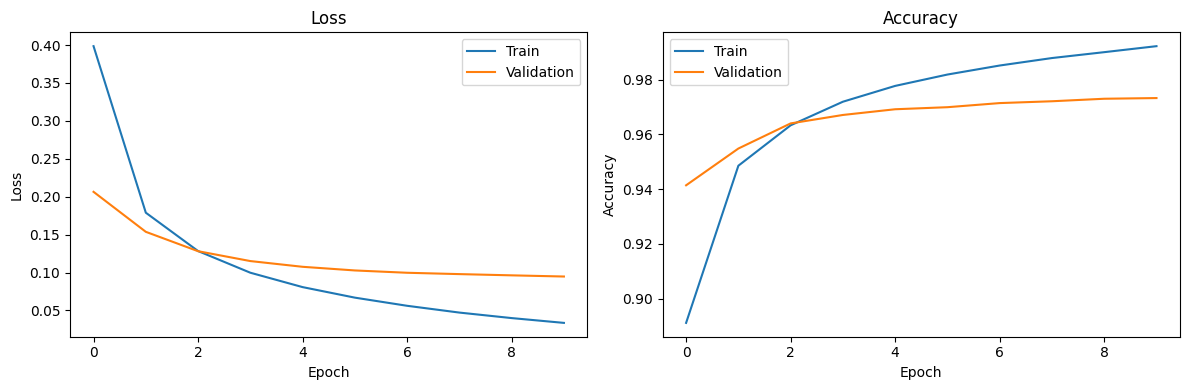

In [25]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history["loss"], label="Train")
ax1.plot(history.history["val_loss"], label="Validation")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.set_title("Loss")

ax2.plot(history.history["accuracy"], label="Train")
ax2.plot(history.history["val_accuracy"], label="Validation")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.set_title("Accuracy")

plt.tight_layout()
plt.show()

### 5.5 Evaluation and Inference

In [26]:
# Evaluate on the full test set
test_loss, test_acc = model.evaluate(test_images, test_labels_onehot)
print(f"\nTest accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9712 - loss: 0.0976

Test accuracy: 0.9753


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


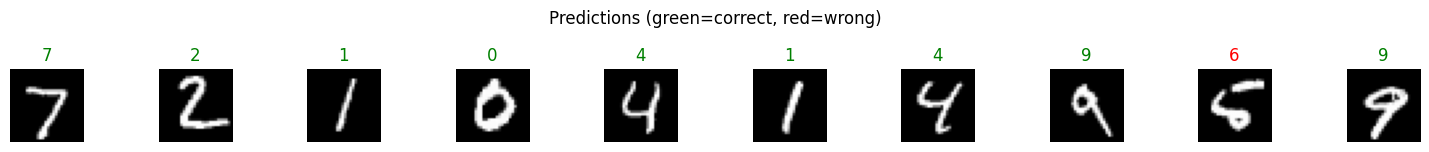

In [27]:
# Make predictions on individual digits
predictions = model.predict(test_images[:10])

fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i, ax in enumerate(axes):
    ax.imshow(test_images[i].reshape(28, 28), cmap="gray")
    pred_label = np.argmax(predictions[i])
    true_label = test_labels[i]
    color = "green" if pred_label == true_label else "red"
    ax.set_title(f"{pred_label}", color=color, fontsize=12)
    ax.axis("off")
plt.suptitle("Predictions (green=correct, red=wrong)")
plt.tight_layout()
plt.show()

### 5.6 The Power of Keras: Adding a Layer

Want to make the model deeper? Just add another line. No need to rewrite any gradient logic.

In [28]:
deeper_model = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax"),
])

deeper_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

deeper_model.fit(train_images, train_labels_onehot,
                 epochs=10, batch_size=128, validation_split=0.2, verbose=1)

test_loss, test_acc = deeper_model.evaluate(test_images, test_labels_onehot)
print(f"\nDeeper model test accuracy: {test_acc:.4f}")

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8478 - loss: 0.5499 - val_accuracy: 0.9603 - val_loss: 0.1365
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9626 - loss: 0.1254 - val_accuracy: 0.9682 - val_loss: 0.1048
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9768 - loss: 0.0783 - val_accuracy: 0.9713 - val_loss: 0.0943
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9838 - loss: 0.0558 - val_accuracy: 0.9723 - val_loss: 0.0938
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9885 - loss: 0.0402 - val_accuracy: 0.9721 - val_loss: 0.1000
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9911 - loss: 0.0298 - val_accuracy: 0.9704 - val_loss: 0.1103
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9936 - loss: 0.0236 - val_accuracy: 0.9736 - val_loss: 0.1053
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9939 - loss: 0.0204 - val_accuracy: 

---
## 6. The Keras Workflow (Summary)

Here's the standard deep learning workflow we'll use throughout the rest of the course:

```
1. Define the model     →  keras.Sequential([...])
2. Configure learning   →  model.compile(optimizer, loss, metrics)
3. Train                →  model.fit(X_train, y_train, ...)
4. Evaluate             →  model.evaluate(X_test, y_test)
5. Predict              →  model.predict(X_new)
```

Under the hood, Keras uses whichever backend you've chosen (TensorFlow, PyTorch, or JAX) to handle tensors, gradients, and GPU computation. You get the simplicity of five method calls with the power of the low-level framework.

---
## Summary

**What we covered:**

- **TensorFlow**: `tf.Variable`, `GradientTape`, compilation with `@tf.function`
- **PyTorch**: mutable tensors, `.backward()` + `.grad`, `torch.nn.Module` for packaging models
- **JAX**: stateless design, `jax.grad` / `jax.value_and_grad`, `@jax.jit`, explicit PRNG keys
- **Keras**: high-level API - `Layer`, `Sequential`, `compile()`, `fit()`, `evaluate()`, `predict()`

**The big picture:** All four frameworks solve the same fundamental problem - training neural networks via gradient descent. They differ in abstraction level and design philosophy. In this course, we'll primarily use **Keras** for building and training models, while understanding the low-level mechanics happening underneath.